<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mask-R-CNN---One-Shot-Version" data-toc-modified-id="Mask-R-CNN---One-Shot-Version-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mask R-CNN - One Shot Version</a></span></li><li><span><a href="#Data-Preperation" data-toc-modified-id="Data-Preperation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preperation</a></span></li><li><span><a href="#One-Shot-Inference" data-toc-modified-id="One-Shot-Inference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>One Shot Inference</a></span><ul class="toc-item"><li><span><a href="#Define-an-anchor" data-toc-modified-id="Define-an-anchor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define an anchor</a></span></li><li><span><a href="#Detect" data-toc-modified-id="Detect-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Detect</a></span></li><li><span><a href="#Visualize-Rois" data-toc-modified-id="Visualize-Rois-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Visualize Rois</a></span></li></ul></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#Bounding-Box-Visualization" data-toc-modified-id="Bounding-Box-Visualization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Bounding Box Visualization</a></span></li><li><span><a href="#Feature-Map" data-toc-modified-id="Feature-Map-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Feature Map</a></span></li><li><span><a href="#Spectrogram-Like-Plotting" data-toc-modified-id="Spectrogram-Like-Plotting-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Spectrogram-Like Plotting</a></span></li></ul></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Metrics</a></span><ul class="toc-item"><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Confusion Matrix</a></span></li><li><span><a href="#Precision-and-recall" data-toc-modified-id="Precision-and-recall-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Precision and recall</a></span></li></ul></li><li><span><a href="#Clustering-Metrics" data-toc-modified-id="Clustering-Metrics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Clustering Metrics</a></span></li><li><span><a href="#Natural-Images" data-toc-modified-id="Natural-Images-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Natural Images</a></span></li></ul></div>

## Mask R-CNN - One Shot Version

In the document we can run one-shot detection of wireframes using Mask R-CNN as the backbone of that analysis. 

In [11]:
# Only run this block on Google CoLab
# !git clone https://github.com/Holstrup/Mask_RCNN 
# import os
# os.chdir("Mask_RCNN/samples/wireframe")

In [12]:
import os
import sys
import random
import numpy as np
import matplotlib.patches as patches
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
from samples.wireframe.WireframeGenerator import generate_data_2
import samples.wireframe.plots as plots
from samples.wireframe import Wireframe
import samples.wireframe.database_actions as db
from mpl_toolkits.mplot3d import Axes3D
import samples.wireframe.metrics as metrics
import samples.wireframe.knn as knn
from sklearn.utils.extmath import softmax
import matplotlib.pyplot as plt
import sklearn.decomposition as sk_decomp
from database_actions import add_encoding, reinitialize_table
from knn import overlaps_bool
from model_triplet import Model

%matplotlib inline 

## Data Preperation

This block prepares the data for us

First we need to generate some data, if the data is not already there. Note that, if you already have the data, you can simply skip this block. 
The function will create an additional 20% of images, that will be used as validation. 

In [13]:
NUM_TRAINING_IMAGES = 100
MAX_ICONS_PER_IMAGE = 3
generate_data_2(NUM_TRAINING_IMAGES, MAX_ICONS_PER_IMAGE)

In [14]:
config = Wireframe.WireframeConfig()
WIREFRAME_DIR = os.path.join(ROOT_DIR, "datasets/wireframe")

# Training dataset
dataset_train = Wireframe.WireframeDataset()
dataset_train.load_wireframe(WIREFRAME_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = Wireframe.WireframeDataset()
dataset_val.load_wireframe(WIREFRAME_DIR, "val")
dataset_val.prepare()                   

## One Shot Inference 

Now we are ready to start detecting with our model. In this block we will be able to do two different things: 
1. Define an anchor and store it in our database
2. Detect icons based on the anchors in the database

First we need to load the weights from the pretrained model, and initialize it in inference mode. The model file should be located in the **root folder**

In [15]:
#MODEL_FILE_NAME = model.get_pretrained_weights("mask_rcnn_newdata_20.h5")
MODEL_FILE_NAME = "mask_rcnn_newdata_20.h5"
class InferenceConfig(Wireframe.WireframeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = os.path.join(ROOT_DIR, MODEL_FILE_NAME)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/BotezatuCristian/PycharmProjects/Mask_RCNN/mask_rcnn_newdata_20.h5


Now we need to load the triplet model. Just give the model name and you should be all set

In [16]:
MODEL_NAME = "weights_emb_labels.h5"

triplet_model = Model()
TRIPLET_MODEL_PATH = os.path.join(ROOT_DIR, MODEL_NAME)
triplet_model.model.load_weights(TRIPLET_MODEL_PATH)

Now we randomly pick an image and display it.

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  189.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max: 1200.00000  float64
gt_class_id              shape: (2,)                  min:    2.00000  max:    5.00000  int64
gt_bbox                  shape: (2, 4)                min:  199.00000  max:  855.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


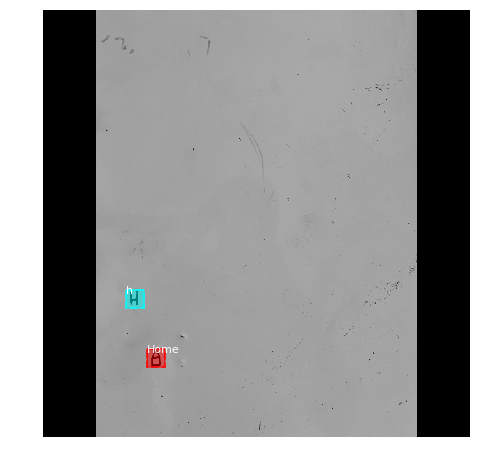

In [17]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

The next two functions might look similar in naming style, but they do different things. The OneShotAnchor function, is meant for you to tell our model "*hey! here's a new icon I'd like for you to be able to classify from now on*". Be aware, that the function only accepts images with **ONE** icon in it. <br/>
The OneShotDetect function is meant to detect all icons on a given image, and output their labels, based on the one-shots the models has been given before through the OneShotAnchor function. 

### Define an anchor

Please specify the label

In [67]:
LABEL = "Search"
model.OneShotAnchor(original_image, LABEL, triplet_model.model)

### Detect

For each icon on the image, it outputs the top 2 guesses, along with the normalized distance.

In [18]:
results = model.OneShotDetect(original_image, triplet_model.model, 3)
results[2]

[1. 0.]


[[('Home', 0.3157745), ('Home', 0.3157745), ('Done', 0.3322911)],
 [('Home', 0.31633362), ('Home', 0.31633362), ('Done', 0.33259764)]]

In [19]:
results[3]

[('Home', 0.31633362), ('Home', 0.3157745)]

In [20]:
Top_elements = [item[0] for item in results[2]]
real_caption = []
rois = np.zeros((1, 4))
for pred in results[3]:
    newroi = results[0]['rois'][Top_elements.index(pred)]
    rois = np.vstack((rois, newroi))
    real_caption.append(pred[0])
rois = rois[1:, :]

### Visualize Rois

This function outputs only the top predictions. Still needs more testing though

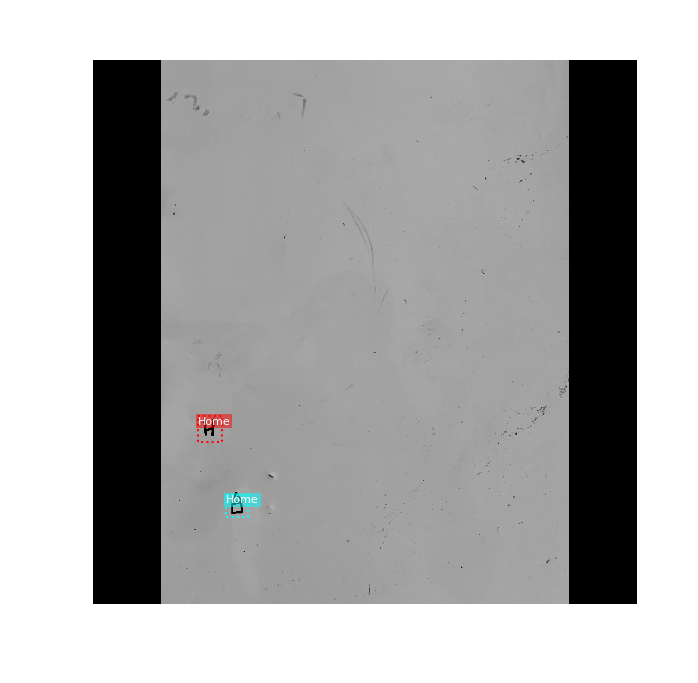

In [21]:
visualize.draw_boxes(original_image, rois, captions = real_caption)

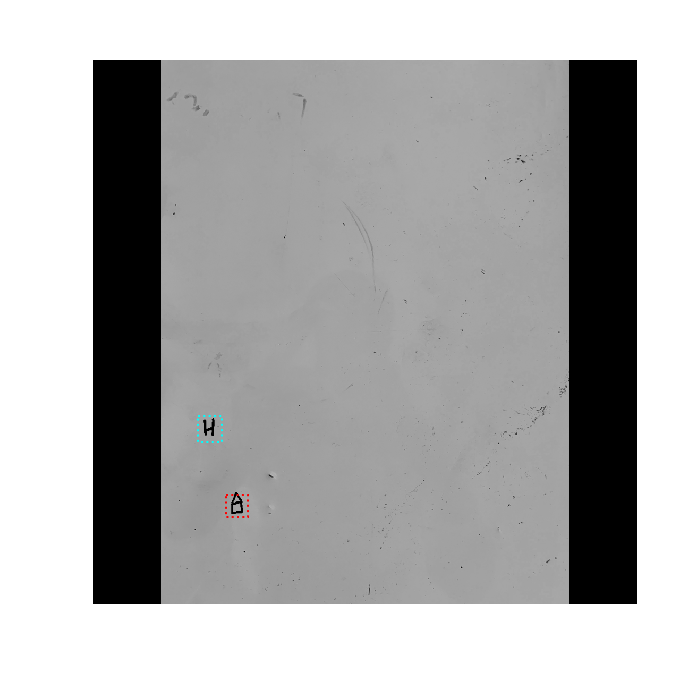

In [22]:
visualize.draw_boxes(original_image, results[0]['rois'])

## KNN is used to classify the embeddings

In [23]:
import knn
from sklearn.model_selection import train_test_split
from database_actions import get_known_encodings
import model_triplet

embeddings, labels = get_known_encodings('Database_emb_labels.db', 1024)
X_train, X_test, y_train, y_test = train_test_split(embeddings.T, labels, test_size=0.25, random_state=0)

X_test = triplet_model.model.predict(X_test)
Test_train, Test_test, testy_train, testy_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

for i in range(10):
    print(knn.knn(Test_test[i], Test_train.T, testy_train, 3))

[(3, 1.1994759e-05), (2, 7.339073e-05), (2, 0.0001785164)]
[(5, 1.2248481e-05), (5, 6.797768e-05), (3, 0.0001260254)]
[(1, 0.00010646325), (4, 0.00023633623), (1, 0.00026412244)]
[(8, 0.00012236774), (8, 0.0004500955), (8, 0.0011668566)]
[(7, 0.0004515017), (4, 0.0012002148), (4, 0.0012038824)]
[(3, 0.0003022786), (2, 0.00037756882), (6, 0.00058358005)]
[(1, 1.2781776e-05), (1, 2.2280963e-05), (1, 2.4462146e-05)]
[(1, 4.5758123e-05), (7, 0.0001179696), (4, 0.00018048799)]
[(3, 2.3028233e-06), (2, 0.00015049953), (2, 0.00024348806)]
[(3, 5.565349e-05), (6, 0.00036328388), (3, 0.0006633651)]


Confusion matrix, without normalization
[[ 4  0  0  3  0  0  0  1  0]
 [ 0  8  0  0  1  0  0  0  0]
 [ 0  5  4  0  1  0  0  3  0]
 [ 8  0  0  8  0  0  0  1  0]
 [ 0  3  6  0  0  0  0  0  0]
 [ 2  2  3  0  0  5  0  1  0]
 [ 8  0  1  4  0  1  1  0  0]
 [ 1  0  0  1  0  2  0 10  0]
 [ 0  0  2  0  0  3  0  1  0]]


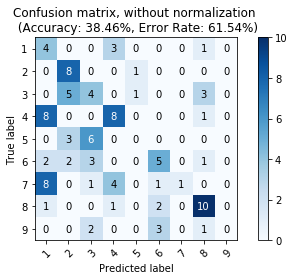

In [24]:
prediction = []

for i in range(len(Test_test)):
    prediction.append(knn.calc_mode(knn.knn(Test_test[i], Test_train.T, testy_train, 3)))
    
pred = [int(i[0][1]) for i in prediction[1:]]
true = [i for i in testy_test[1:]]
confusion_matrix = plots.plot_confusion_matrix(true, pred, normalize=False)

## Visualizations

This block is under construction. The intent is to give us some overview of how our data looks. As of right now, the block includes: 
1. Bounding Box visualization
2. Feature map plotting 
3. A spectrogram-like plotting of our features.  

### Bounding Box Visualization

This visualization will show you how where the bounding boxes are located on the image. This can be useful when the one shot predictions give some weird results. In that case it us useful to see exactly where the bounding boxes are, in order to give some idea of why the results are the way they are. 

In [ ]:
#True and pred bbox
original_image, _, gt_class_id, bboxTrue, _ =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
result = model.detect([original_image], verbose=1)
bboxPred = result[0]['rois']

#Relevant bbox
relevantbbox = []
indexTrue = knn.overlapsTrueAndPredicted(bboxTrue, bboxPred)
for i in range(len(indexTrue)):
  relevantbbox.append(bboxPred[i])

print("Predict", bboxPred)
print("Relevant", np.array(relevantbbox))

#Draw relevant bbox (filter from all the predicted bboxes)
visualize.draw_boxes(original_image, np.array(relevantbbox))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  189.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   85.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [4]:
indicies = [3, 4, 5, 6]
maps = []
label = []

embeddings, labels = db.get_known_encodings()
for i in range(len(indicies)):
  maps.append(embeddings[:, indicies[i]])
  label.append(labels[indicies[i]])

embeddings = np.stack(maps, axis=1)

### Feature Map
This will show you a feature map of the embedding vectors. It can be useful to see, if they resemble each other in some way. Often then won't, but you maybe you get lucky. <br/>
A more technical note: The feature maps are simply contructed by reshaping the (,1024) vector to (32,32), thus you cannot expect to see any resemblance to the actual icons or anything. 

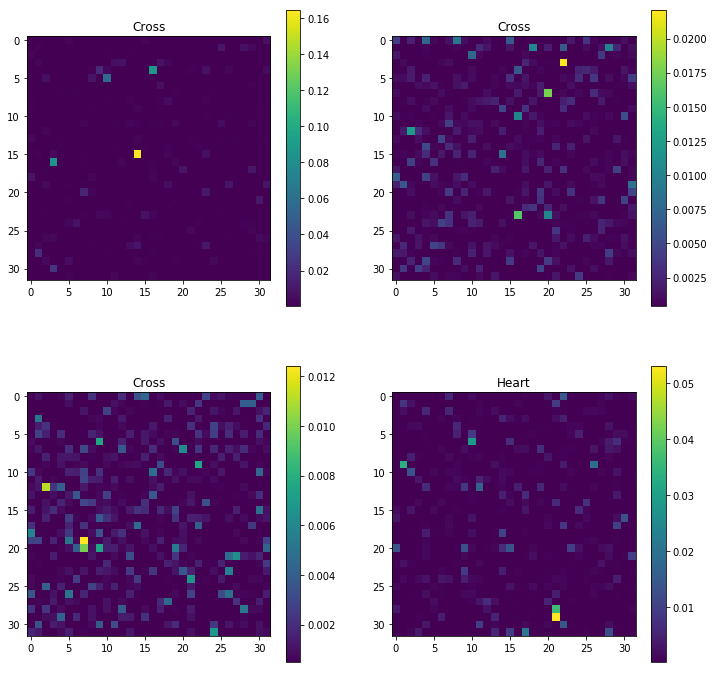

In [29]:
plots.feature_maps(embeddings, label)

### Spectrogram-Like Plotting
This is a very similar plot to the feature map. This just plots the embedding vectors without reshaping them, so you get more of a histogram-like plot. 

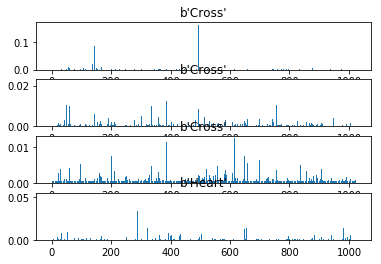

In [30]:
plots.histogram_plot(embeddings, label)

## Metrics
This block is under construction. It should give us some metrics of how well our classifier is doing. We aim to implement: 
1. A Confusion Matrix 
2. Precision and Recall
3. Different Clustering Metrics

### Confusion Matrix

Here we can look at how well our classifier is doing, by producing a confusion matrix. When using it, you have two options. 
1. How many images do you want to evaluate over? 
2. Do you want to normalize the confusion matrix? 

Note, that the function is quite computationally expensive. 

In [20]:
EVALUATE = 5 #Images
NORMALIZE = False

In [ ]:
class_names = dataset_train.class_names
real_label = []
pred_label = []

for _ in range(EVALUATE):
    image_id = random.choice(dataset_val.image_ids)
    
    #True and pred bbox
    original_image, _, gt_class_id, bboxTrue, _ =\
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    result = model.detect([original_image])
    bboxPred = result[0]['rois']
    
    #Take only the relevant pred boundary boxes
    relevantbbox = []
    relevantbboxLabel = []
    indexTrue = knn.overlapsTrueAndPredicted(bboxTrue, bboxPred)

    #Choose the relevant r (predicted with less noise)
    r, _ = model.OneShotDetect(original_image)
    r = list(r.values())
    r = [i[0][0].decode("utf-8") for i in r]
    print("r", r)
    relevantR = []
    for i in range(len(indexTrue)):
      relevantR.append(r[i])
    print("relevantR", relevantR)
      
    #Take the true samples
    foo = [class_names[i] for i in gt_class_id]
    print("foo", foo)

    #Sort the arrays
    if len(r) != len(foo):
        continue
    elif set(r) == set(foo):
        real_label.extend(foo)
        pred_label.extend(relevantR)
    else:
        real_label.extend(foo)
        pred_label.extend(relevantR)

confusion_matrix =\
        plots.plot_confusion_matrix(real_label, pred_label, normalize=NORMALIZE)

### Precision and recall

In [ ]:
true_positive = np.sum(np.diagonal(confusion_matrix))
false_positive = np.sum(confusion_matrix) - np.sum(np.diagonal(confusion_matrix))
false_negative = false_positive

# Precision
Precision = true_positive/(true_positive + false_positive)

# Recall
Recall = true_positive/(true_positive + false_negative)

# F1
F1 = 2*(Precision*Recall)/(Precision + Recall)

print("Precision: " + str(Precision) + "\n" + "Recall: " + str(Recall) + "\n" + "F1: " + str(F1))

## Clustering Metrics
* Silhouette Score
* ARI
* AMI
* Homogenity
* Completeness
* V-measure

In [34]:
# Load the data and define the necessary variables
embeddings, labels = db.get_known_encodings("Database.db")
embeddings = np.transpose(embeddings)

In [42]:
print(np.shape(embeddings))

(8, 128)


In [45]:
metrics.metricFunction(embeddings,labels,4)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 8, n_neighbors = 10

## Natural Images

The idea of this section, is to upload an image that doesn't have any mask or bounding box pre-defined. Images used in this section needs to be uploaded to the "predict" folder. 

In [8]:
WIREFRAME_DIR = os.path.join(ROOT_DIR, "datasets/wireframe")
dataset_predict = Wireframe.WireframeDataset()
dataset_predict.load_natural_image(WIREFRAME_DIR, "predict")

[1, 0]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


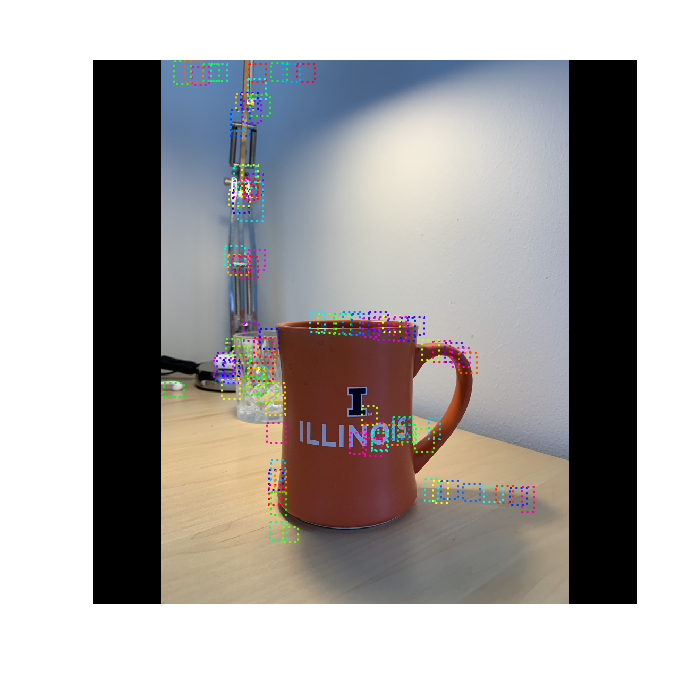

In [9]:
IMAGE_ID = 1
# Load image
image = dataset_predict.load_image(IMAGE_ID)
image, _, _, _, _ = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)
results = model.detect([image], verbose=1)
visualize.draw_boxes(image, results[0]['rois'])